# Starting comments
Hud Wahab, AI Materials Group, UWYO, 2019.

# Importing libraries
So the first part will be to import a bunch of libraries for doing various things

In [313]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/envs/Raman/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'step', 'partition', '__version__', 'uniform', 'subplots', 'log2', 'array', 'logistic', 'exponential', 'random', 'erf', 'lognormal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [503]:
from scipy.optimize import curve_fit

from fastai.basics import *

import lmfit
from lmfit.models import *
from lmfit.lineshapes import *
from lmfit import Parameters, fit_report, minimize

import rampy as rp #Charles' libraries and functions

# Importing and looking at the data
Let's see our raw data structure and maybe clean it up.

In [462]:
path = Path('../data/Alex/Data')
path.ls()[:5]

[PosixPath('../data/Alex/Data/2019-02-17  GO20_s1_lp600mW_dur3000ms_p80psi.csv'),
 PosixPath('../data/Alex/Data/model4param.R'),
 PosixPath('../data/Alex/Data/2019-02-18  GO20_s1_lp880mW_dur4478ms_p95psi.csv'),
 PosixPath('../data/Alex/Data/2019-02-17  GO20_s1_lp600mW_dur1000ms_p50psi.csv'),
 PosixPath('../data/Alex/Data/2019-02-19  GO20_s1_lp940mW_dur11458ms_p85psi_3.csv')]

In [463]:
parent=[x.parents[0] for x in path.rglob("*.[cC][sS][vV]")]
child=[x.name for x in path.rglob("*s1*.[cC][sS][vV]")]
child.extend([x.name for x in path.rglob("*pre*.[cC][sS][vV]")])
child.extend([x.name for x in path.rglob("*bgr*.[cC][sS][vV]")])

In [464]:
parent[:5]

[PosixPath('../data/Alex/Data'),
 PosixPath('../data/Alex/Data'),
 PosixPath('../data/Alex/Data'),
 PosixPath('../data/Alex/Data'),
 PosixPath('../data/Alex/Data')]

In [466]:
child[-10:]

['2019-02-18  GO20_s1_lp920mW_dur8374ms_p90psi_2.csv',
 '2019-02-19  GO20_s1_lp930mW_dur8972ms_p85psi_2.csv',
 '2019-02-17  GO20_s1_lp620mW_dur600ms_p80psi.csv',
 '2019-02-19  GO20_s1_lp930mW_dur8972ms_p85psi_3.csv',
 '2019-02-18  GO20_s1_lp920mW_dur8374ms_p90psi_3.csv',
 '2019-02-20  G020_pre.csv',
 '2019-02-20  G020_pre_2.csv',
 '2019-02-20  G020_pre_3.csv',
 '2019-02-17  GO20_bgr.csv',
 '2019-02-18  GO20_bgr.csv']

In [467]:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [468]:
def load_data(parent, child):
    dfs=[]
    for p,c in zip(parent,child):
        dfs.append(pd.read_csv(p/c, skiprows=[0], header=None, names=['W_'+str(c[10:]),c]))
    return pd.concat(dfs,axis=1)  # care: works only when all E column values are the same

In [469]:
df=load_data(parent,child)
df.head()

,W_ GO20_s1_lp600mW_dur3000ms_p80psi.csv,2019-02-17 GO20_s1_lp600mW_dur3000ms_p80psi.csv,W_ GO20_s1_lp880mW_dur4478ms_p95psi.csv,2019-02-18 GO20_s1_lp880mW_dur4478ms_p95psi.csv,W_ GO20_s1_lp600mW_dur1000ms_p50psi.csv,2019-02-17 GO20_s1_lp600mW_dur1000ms_p50psi.csv,W_ GO20_s1_lp940mW_dur11458ms_p85psi_3.csv,2019-02-19 GO20_s1_lp940mW_dur11458ms_p85psi_3.csv,W_ GO20_s1_lp1050mW_dur7462ms_p85psi.csv,2019-02-18 GO20_s1_lp1050mW_dur7462ms_p85psi.csv,...,W_ G020_pre.csv,2019-02-20 G020_pre.csv,W_ G020_pre_2.csv,2019-02-20 G020_pre_2.csv,W_ G020_pre_3.csv,2019-02-20 G020_pre_3.csv,W_ GO20_bgr.csv,2019-02-17 GO20_bgr.csv,W_ GO20_bgr.csv,2019-02-18 GO20_bgr.csv
0,567.822060,1900,567.822060,3082,567.822060,31065,567.822060,3000,567.683778,3567,...,567.822060,11312,567.822060,8385,567.822060,6877,567.822060,1407,567.822060,1352
1,567.837933,1932,567.837933,3084,567.837933,31085,567.837933,3114,567.699655,3566,...,567.837933,11394,567.837933,8435,567.837933,6762,567.837933,1391,567.837933,1365
2,567.853805,1929,567.853805,3140,567.853805,30944,567.853805,3043,567.715532,3627,...,567.853805,11300,567.853805,8390,567.853805,6914,567.853805,1364,567.853805,1336
3,567.869676,1937,567.869676,3091,567.869676,31108,567.869676,3036,567.731407,3619,...,567.869676,11326,567.869676,8394,567.869676,7655,567.869676,1376,567.869676,1319
4,567.885545,1943,567.885545,3029,567.885545,31190,567.885545,3032,567.747280,3544,...,567.885545,11420,567.885545,8433,567.885545,7035,567.885545,1407,567.885545,1344


In [470]:
df = df.drop(df.columns[2::2], 1)  # CARE! this doesnt work if the columns to be dropped have the same name
df.head()

,W_ GO20_s1_lp600mW_dur3000ms_p80psi.csv,2019-02-17 GO20_s1_lp600mW_dur3000ms_p80psi.csv,2019-02-18 GO20_s1_lp880mW_dur4478ms_p95psi.csv,2019-02-17 GO20_s1_lp600mW_dur1000ms_p50psi.csv,2019-02-19 GO20_s1_lp940mW_dur11458ms_p85psi_3.csv,2019-02-18 GO20_s1_lp1050mW_dur7462ms_p85psi.csv,2019-02-18 GO20_s1_lp920mW_dur8431ms_p90psi.csv,2019-02-19 GO20_s1_lp940mW_dur10007ms_p85psi.csv,2019-02-19 GO20_s1_lp940mW_dur11458ms_p85psi_2.csv,2019-02-18 GO20_s1_lp100mW_dur1500ms_p60psi.csv,...,2019-02-18 GO20_s1_lp920mW_dur8374ms_p90psi_2.csv,2019-02-19 GO20_s1_lp930mW_dur8972ms_p85psi_2.csv,2019-02-17 GO20_s1_lp620mW_dur600ms_p80psi.csv,2019-02-19 GO20_s1_lp930mW_dur8972ms_p85psi_3.csv,2019-02-18 GO20_s1_lp920mW_dur8374ms_p90psi_3.csv,2019-02-20 G020_pre.csv,2019-02-20 G020_pre_2.csv,2019-02-20 G020_pre_3.csv,2019-02-17 GO20_bgr.csv,2019-02-18 GO20_bgr.csv
0,567.822060,1900,3082,31065,3000,3567,2956,2421,2932,1771,...,2657,2271,1959,2238,2597,11312,8385,6877,1407,1352
1,567.837933,1932,3084,31085,3114,3566,3020,2431,2943,1767,...,2615,2268,1907,2299,2588,11394,8435,6762,1391,1365
2,567.853805,1929,3140,30944,3043,3627,2994,2409,2937,1801,...,2677,2278,1922,2245,2599,11300,8390,6914,1364,1336
3,567.869676,1937,3091,31108,3036,3619,2966,2389,2923,1770,...,2629,2251,1935,2259,2578,11326,8394,7655,1376,1319
4,567.885545,1943,3029,31190,3032,3544,2943,2416,2967,1768,...,2656,2317,1912,2276,2622,11420,8433,7035,1407,1344


In [471]:
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: 1e7/532-1e7/x)  # changing emission wavelength to relative wavenumber

In [472]:
df.head()

,W_ GO20_s1_lp600mW_dur3000ms_p80psi.csv,2019-02-17 GO20_s1_lp600mW_dur3000ms_p80psi.csv,2019-02-18 GO20_s1_lp880mW_dur4478ms_p95psi.csv,2019-02-17 GO20_s1_lp600mW_dur1000ms_p50psi.csv,2019-02-19 GO20_s1_lp940mW_dur11458ms_p85psi_3.csv,2019-02-18 GO20_s1_lp1050mW_dur7462ms_p85psi.csv,2019-02-18 GO20_s1_lp920mW_dur8431ms_p90psi.csv,2019-02-19 GO20_s1_lp940mW_dur10007ms_p85psi.csv,2019-02-19 GO20_s1_lp940mW_dur11458ms_p85psi_2.csv,2019-02-18 GO20_s1_lp100mW_dur1500ms_p60psi.csv,...,2019-02-18 GO20_s1_lp920mW_dur8374ms_p90psi_2.csv,2019-02-19 GO20_s1_lp930mW_dur8972ms_p85psi_2.csv,2019-02-17 GO20_s1_lp620mW_dur600ms_p80psi.csv,2019-02-19 GO20_s1_lp930mW_dur8972ms_p85psi_3.csv,2019-02-18 GO20_s1_lp920mW_dur8374ms_p90psi_3.csv,2019-02-20 G020_pre.csv,2019-02-20 G020_pre_2.csv,2019-02-20 G020_pre_3.csv,2019-02-17 GO20_bgr.csv,2019-02-18 GO20_bgr.csv
0,1185.841556,1900,3082,31065,3000,3567,2956,2421,2932,1771,...,2657,2271,1959,2238,2597,11312,8385,6877,1407,1352
1,1186.333852,1932,3084,31085,3114,3566,3020,2431,2943,1767,...,2615,2268,1907,2299,2588,11394,8435,6762,1391,1365
2,1186.826079,1929,3140,30944,3043,3627,2994,2409,2937,1801,...,2677,2278,1922,2245,2599,11300,8390,6914,1364,1336
3,1187.318237,1937,3091,31108,3036,3619,2966,2389,2923,1770,...,2629,2251,1935,2259,2578,11326,8394,7655,1376,1319
4,1187.810326,1943,3029,31190,3032,3544,2943,2416,2967,1768,...,2656,2317,1912,2276,2622,11420,8433,7035,1407,1344


In [473]:
df = df.rename(columns={df.columns[0]: "Wavenumber" })
df.head()

,Wavenumber,2019-02-17 GO20_s1_lp600mW_dur3000ms_p80psi.csv,2019-02-18 GO20_s1_lp880mW_dur4478ms_p95psi.csv,2019-02-17 GO20_s1_lp600mW_dur1000ms_p50psi.csv,2019-02-19 GO20_s1_lp940mW_dur11458ms_p85psi_3.csv,2019-02-18 GO20_s1_lp1050mW_dur7462ms_p85psi.csv,2019-02-18 GO20_s1_lp920mW_dur8431ms_p90psi.csv,2019-02-19 GO20_s1_lp940mW_dur10007ms_p85psi.csv,2019-02-19 GO20_s1_lp940mW_dur11458ms_p85psi_2.csv,2019-02-18 GO20_s1_lp100mW_dur1500ms_p60psi.csv,...,2019-02-18 GO20_s1_lp920mW_dur8374ms_p90psi_2.csv,2019-02-19 GO20_s1_lp930mW_dur8972ms_p85psi_2.csv,2019-02-17 GO20_s1_lp620mW_dur600ms_p80psi.csv,2019-02-19 GO20_s1_lp930mW_dur8972ms_p85psi_3.csv,2019-02-18 GO20_s1_lp920mW_dur8374ms_p90psi_3.csv,2019-02-20 G020_pre.csv,2019-02-20 G020_pre_2.csv,2019-02-20 G020_pre_3.csv,2019-02-17 GO20_bgr.csv,2019-02-18 GO20_bgr.csv
0,1185.841556,1900,3082,31065,3000,3567,2956,2421,2932,1771,...,2657,2271,1959,2238,2597,11312,8385,6877,1407,1352
1,1186.333852,1932,3084,31085,3114,3566,3020,2431,2943,1767,...,2615,2268,1907,2299,2588,11394,8435,6762,1391,1365
2,1186.826079,1929,3140,30944,3043,3627,2994,2409,2937,1801,...,2677,2278,1922,2245,2599,11300,8390,6914,1364,1336
3,1187.318237,1937,3091,31108,3036,3619,2966,2389,2923,1770,...,2629,2251,1935,2259,2578,11326,8394,7655,1376,1319
4,1187.810326,1943,3029,31190,3032,3544,2943,2416,2967,1768,...,2656,2317,1912,2276,2622,11420,8433,7035,1407,1344


## Data plots

In [474]:
standardFonts = {'family' : 'Arial',
                 'size' : 14}

subplotLabels = {'fontsize': rcParams['axes.titlesize'],
                 'fontweight' : 'bold',
                 'verticalalignment': 'baseline',
                 'horizontalalignment': 'left'}
    
matplotlib.rc('font', **standardFonts)
mpl.rcParams['mathtext.fontset']  = 'dejavuserif'
mpl.rcParams['font.family']       = 'Arial'
matplotlib.rc('font', **standardFonts)

mpl.rcParams['xtick.major.size']  = 8
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size']  = 4
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['xtick.direction']   = 'in'
mpl.rcParams['xtick.top']         = True
mpl.rcParams['xtick.bottom']      = True
mpl.rcParams['xtick.labelsize']   = 16
mpl.rcParams['ytick.major.size']  = 8
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size']  = 4
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['ytick.direction']   = 'in'
mpl.rcParams['ytick.left']        = True
mpl.rcParams['ytick.right']       = True
mpl.rcParams['ytick.labelsize']   = 16

mpl.rcParams['axes.linewidth']    = 2
mpl.rcParams['axes.titlesize']    = 20
mpl.rcParams['axes.titleweight']  = 'bold'
mpl.rcParams['axes.labelweight']  = 'bold'
mpl.rcParams['axes.labelsize']    = 16

In [551]:
x = df['Wavenumber']
y = df['2019-02-18  GO20_s1_lp960mW_dur10292ms_p90psi_3.csv']
y0 = df['2019-02-20  G020_pre_3.csv']
bg = df['2019-02-18  GO20_bgr.csv']

Text(0.5, 1.0, 'Fig. 1: the raw data')

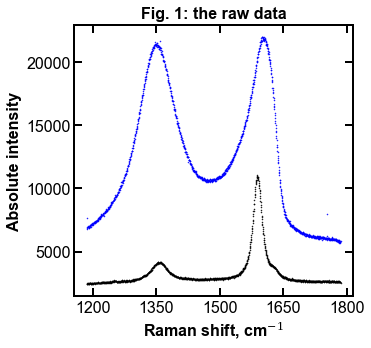

In [552]:
# create a new plot for showing the spectrum
# ax = plt.axes()
fig, ax = plt.subplots(1, figsize=(5, 5))
# plt.figure(figsize=(5,5))

plt.plot(x,y,'k.',markersize=1)
plt.plot(x,y0,'b.',markersize=1)
# plt.plot(x2,y2,'b.',markersize=1)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
# plt.xticks(np.arange(min(x), max(x), 200))
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 16)
plt.ylabel("Absolute intensity", fontsize = 16)
plt.title("Fig. 1: the raw data",fontsize = 16,fontweight="bold")

Text(0.5, 1.0, 'Fig. 2: background removal')

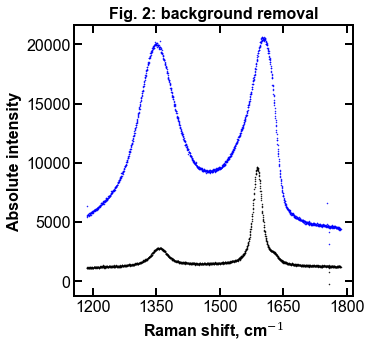

In [553]:
fig, ax = plt.subplots(1, figsize=(5, 5))
# plt.figure(figsize=(5,5))

plt.plot(x,y-bg,'k.',markersize=1)
plt.plot(x,y0-bg,'b.',markersize=1)
# plt.plot(x2,y2,'b.',markersize=1)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
# plt.xticks(np.arange(min(x), max(x), 200))
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 16)
plt.ylabel("Absolute intensity", fontsize = 16)
plt.title("Fig. 2: background removal",fontsize = 16,fontweight="bold")

We are interested in fitting the 870-1300 cm$^{-1}$ portion of this spectrum, which can be assigned to the various symmetric and assymetric stretching vibrations of Si-O bonds in the SiO$_2$ tetrahedra present in the glass network (see the above cited litterature for details).


# Baseline Removal

First thing we notice in Fig. 1, we have to remove a baseline because this spectrum is shifted from 0 by some "background" scattering. For that, we can use the rp.baseline() function

In [554]:
bir = np.array([(1198,1200),(1778,1780)]) # The regions where the baseline will be fitted

y_corr, y_base = rp.baseline(x.values, y.values, bir,'poly', polynomial_order=1)# We fit a polynomial background.
y0_corr, y0_base = rp.baseline(x.values, y0.values, bir,'poly', polynomial_order=1)

/anaconda3/envs/Raman/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/envs/Raman/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/envs/Raman/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/envs/Raman/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Text(0.5, 1.0, 'Fig. 2: subtracted to 0')

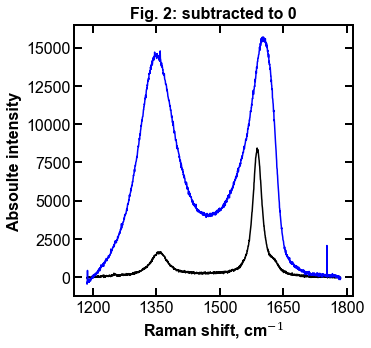

In [555]:
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.plot(x,y_corr,'k')
plt.plot(x,y0_corr,'b')
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 16)
plt.ylabel("Absoulte intensity", fontsize = 16)
plt.title("Fig. 2: subtracted to 0",fontsize = 16,fontweight="bold")
# plt.plot(x2,y_corr2,'b')

Now we will do some manipulation to have the interested portion of spectrum in a single variable. We will assume that the errors have not been drastically affected by the correction process (in some case it can be, but this one is quite straightforward), such that we will use the initial relative errors stored in the "ese0" variable.

Text(0.5, 1.0, 'Fig. 3: normalised spectrum')

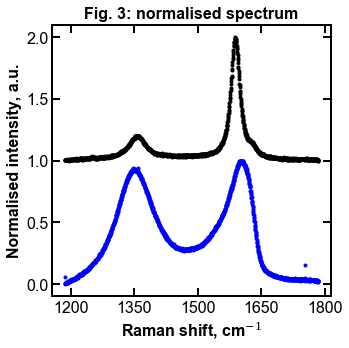

In [556]:
#min-max normalisation
y_mm = (y_corr-y_corr.min())/(y_corr.max()-y_corr.min())
y0_mm = (y0_corr-y0_corr.min())/(y0_corr.max()-y0_corr.min())

fig, ax = plt.subplots(1, figsize=(5, 5))
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.plot(x,y_mm+1,'k.',label='LRG')
plt.plot(x,y0_mm,'b.',label='GO')
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 16)
plt.ylabel("Normalised intensity, a.u.", fontsize = 16)
plt.title("Fig. 3: normalised spectrum",fontsize = 16,fontweight="bold")

# Last steps before fitting the spectrum

So here we are. We have the corrected spectrum in the sample variable. 

But before going further away,we need to write a function for the optimisation. It will return the difference between the calculated and measured spectrum, following the guideline provived by lmfit (http://lmfit.github.io/lmfit-py/) Please note that I do the fitting this way because it gives a pretty good control of the entire process, but you can use directly the builtin models of lmfit (http://lmfit.github.io/lmfit-py/builtin_models.html) for fitting the spectrum. Doing so, your code will be different from this one and you don't need to define a residual function. In such case, you want to look at the example 3 on the page http://lmfit.github.io/lmfit-py/builtin_models.html. But let's just pretend we want to write our own piece of code and use the Gaussian function implemented in Rampy.

The shape of the spectrum suggests that at least three peaks are present, because of the two obvious bands near 950 and 1080 cm$^{-1}$ and a slope break near 1200 cm $^{-1}$. From previous works, we actually know that we have two additional peaks (See Mysen, 1990 or Le Losq et al., 2014) in this spectral region located near 1050 and 1150 cm$^{-1}$. So we have to fit 5 peaks, and hence, we have 5 intensities variables a1 to a5, 5 frequencies f1 to f5, and 5 half width at half peak maximum l1 to l5. This makes a total of 15 parameters. Those variables will be stored in the Parameters() object created by the lmfit software (see http://lmfit.github.io/lmfit-py/parameters.html), we will go back on this one latter. For now, let just say that the Parameters() object is called "pars" and contains the various a1-a5, f1-f5 and l1-l5 parameters, such that we can have their values with using a1 = pars['a1'].value for instance.

So let's go. We create the function "residual" with arguments pars (the Parameters() object), the x axis, and, in option, the y axis as data and the errors.

In [609]:
def lorentzian_fcn(x, I, x0, gamma):
    return I*((gamma**2)/(((x-x0)**2)+gamma**2))

def two_lorentzian(x, I1, x1, gamma1, I2, x2, gamma2, y_0):
    return lorentzian_fcn(x, I1, x1, gamma1) + lorentzian_fcn(x, I2, x2, gamma2) + y_0 

def b_wigner(x, A, mu, sigma, q):
    return A*(q*sigma/2+x-mu)**2/((sigma/2)**2+(x-mu)**2)

def line(x, m, c):
    return m*x+c

def lor_bw(x, I1, x1, gamma1, A, mu, sigma, q, m, c):
    return lorentzian_fcn(x, I1, x1, gamma1) + b_wigner(x, A, mu, sigma, q) + line(x, m, c)

In [601]:
prms = [150, 1350, 100, 150, 1620, 80, 10]
popt, pcov = curve_fit(two_lorentzian, x, y_mm[:,0], p0 = prms)
df_proc = two_lorentzian(x, *popt)
popt

array([ 1.838737e-01,  1.357095e+03, -2.565941e+01,  9.849730e-01,  1.588879e+03,  1.277056e+01,  9.277730e-03])

In [575]:
prms0 = [150, 1350, 100, 150, 1620, 80, 10]
popt0, pcov0 = curve_fit(two_lorentzian, x, y0_mm[:,0], p0 = prms0)
df_proc0 = two_lorentzian(x, *popt0)
popt0

array([ 9.714766e-01,  1.353814e+03, -6.246042e+01,  1.015984e+00,  1.595663e+03,  4.174002e+01, -9.059708e-02])

In [610]:
prms1 = [1, 1350, 100, 1, 1610, 1, 0.05, 0, 0]
popt1, pcov1 = curve_fit(lor_bw, x, y0_mm[:,0], p0 = prms1)
df_proc1 = lor_bw(x, *popt1)
popt1

array([ 9.221976e-01,  1.349313e+03,  5.288801e+01,  7.495522e-02,  1.613847e+03,  6.746372e+01, -3.553602e+00,
        4.003734e-04, -6.813700e-01])

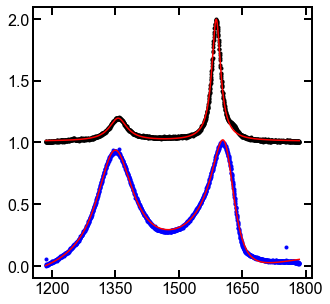

In [611]:
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.plot(x,y_mm+1,'k.',label='LRG')
plt.plot(x,df_proc+1,'r',label='fit')
plt.plot(x,y0_mm,'b.',label='GO')
plt.plot(x,df_proc1,'r',label='fit')

In [578]:
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.plot(x,y_mm+1,'k.',label='LRG')
plt.plot(x,df_proc+1,'r',label='fit')
plt.plot(x,y0_mm,'b.',label='GO')
# plt.plot(x,df_proc1,'r',label='fit')
plt.legend()


plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 16)
plt.ylabel("Normalised intensity, a.u.", fontsize = 16)
plt.title("Fig. 3: normalised spectrum",fontsize = 16,fontweight="bold")
# plt.savefig(path/'Fig3.png', format='png', dpi=300)

Text(0.5, 1.0, 'Fig. 3: normalised spectrum')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1166fd620> (for post_execute):


AttributeError: 'NoneType' object has no attribute 'get_char_index'

AttributeError: 'NoneType' object has no attribute 'get_char_index'

<Figure size 360x360 with 1 Axes>

Note that in the above function, I did not applied the square to (model - data). This is implicitely done by lmfit (see http://lmfit.github.io/lmfit-py/fitting.html#fit-func-label for further information on function writting).

# Fitting

Ok, we have our optimisation function. So we can go forward and fit the spectrum... 

We need five Guassians at 950, 1050, 1100, 1150 and 1200 cm$^{-1}$. We set their half-width at half-maximum at the same value.

In [ ]:
bre

In [267]:
p = lmfit.Parameters()
#         (Name,  Value,  Vary,   Min,  Max,  Expr)
p.add_many(('a1',     50,   True,    0, None,  None),
          ('f1',   1350,   True, 1340, 1360,  None),
          ('l1',     50,   True,   45,   65,  None),
          ('a3',   50,   True,  0,      None,  None),
          ('f3',   1595,  True, 1580,   1600,  None),
          ('l3',   35,   True,  25,   45,  None)) 

For further details on the Parameters() object, I invite you to look at this page: http://lmfit.github.io/lmfit-py/parameters.html . But from the above piece of code, you can already guess that you can make specific parameters that vary or not, you can fixe Min or Max values, and you can even put some contrains between parameters (e.g., "l1 = l2') using the last "Expr" column.

You can remark that we applied some boundaries for the peak positions, but also for peak widths. This is based on previous fits made for this kind of compositions. Typically, in such glass, peaks from Si-O stretch vibrations do not present half-width greater than 50 cm$^{-1}$ or smaller than 20 cm$^{-1}$. For instance, the 1080 cm$^{-1}$ peak typically present a half-width of ~ 30 cm$^{-1}$ ± 5 cm$^{-1}$ in silica-rich silicate glasses, such that we can apply a tighter constrain there. Following such ideas, I put bonds for the parameter values for the half-width of the peaks. This avoid fitting divergence. Furthermore, we know approximately the frequencies of the peaks, such that we can also apply bondaries for them. This will help the fitting, since in this problem, we have five peaks in a broad envelop that only present two significant features at ~950, ~1080 cm$^{-1}$ as well as two barely visible shoulders near 1050 and 1200 cm$^{-1}$. But this is a simple case. For some more complex (aluminosilicate) glasses, this 850-1300 cm$^{-1}$ frequency envelop is even less resolved, such that applying reasonable constrains become crucial for any quantitative Raman fitting.

For starting the fit, as we suppose we have a not bad knowledge of peak frequencies (see the discussion right above), a good thing to do is to fix for the first fit the frequencies of the peaks:

In [268]:
# we constrain the positions
p['f1'].vary = False
# params['f2'].vary = False
p['f3'].vary = False
# params['f4'].vary = False
# params['f5'].vary = False

This avoids any divergence of the fitting procedure regarding the hald-width, because with free frequencies and badly estimated half-width and intensities, the fitting procedure always tends to extremely broaden the peaks and put them at similar frequencies, with strong overlapping. Starting the fitting procedure by fixing the parameter we know the best, i.e. the frequencies, avoid such complications.

Then, we need to use a large-scale algorithm quite robust for fitting. The levenberg-marquart algorithm fails on such fitting problem in my experience. Let's choose the Nelder and Mead algorithm for this example: (http://comjnl.oxfordjournals.org/content/7/4/308.short) :

In [269]:
algo ='nelder'

result = lmfit.minimize(residual, p, method = algo, args=(x_fit, y_pu_mm[:,0])) # fit data with  nelder model from scipy

And now we release the frequencies:

In [270]:
# we release the positions but contrain the FWMH and amplitude of all peaks 
p['f1'].vary = True
# params['f2'].vary = True
p['f3'].vary = True
# params['f4'].vary = True
# params['f5'].vary = True

#we fit twice
result2 = lmfit.minimize(residual, p,method = algo, args=(x_fit, y_pu_mm[:,0])) # fit data with leastsq model from scipy

We can now extract the various things generated by lmfit as well as the peaks:

In [271]:
# model = lmfit.fit_report(result2.params)
yout, peak1,peak3 = residual(result2.params,x_fit) # the different peaks
# rchi2 = (1/(float(len(y_pu_mm))-15-1))*np.sum((y_pu_mm - yout)**2/sigma**2) # calculation of the reduced chi-square 

And let's have a look at the fitted spectrum:

In [273]:
print(fit_report(result2))

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2209
    # data points      = 699
    # variables        = 6
    chi-square         = 2.66449506
    reduced chi-square = 0.00384487
    Akaike info crit   = -3881.17569
    Bayesian info crit = -3853.87778
[[Variables]]
    a1:  209.296082 (init = 50)
    f1:  1357.84781 (init = 1350)
    l1:  65.0000000 (init = 50)
    a3:  102.898595 (init = 50)
    f3:  1582.90722 (init = 1595)
    l3:  45.0000000 (init = 35)


rchi-2 = 
124912.04539588845


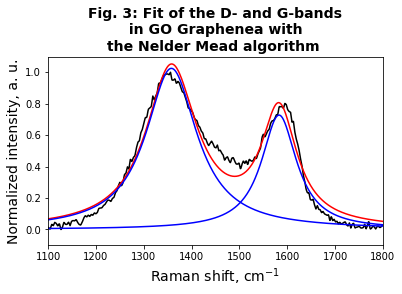

In [241]:
##### WE DO A NICE FIGURE THAT CAN BE IMPROVED FOR PUBLICATION
plt.plot(x_fit,y_pu_mm,'k-')
plt.plot(x_fit,yout,'r-')
plt.plot(x_fit,peak1,'b-')
# plt.plot(x_fit,peak2,'b-')
plt.plot(x_fit,peak3,'b-')
# plt.plot(x_fit,peak4,'b-')
# plt.plot(x_fit,peak5,'b-')
    
plt.xlim(lb,hb)
plt.ylim(-0.1,1.1)
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)
plt.title("Fig. 3: Fit of the D- and G-bands\n in GO Graphenea with \nthe Nelder Mead algorithm ",fontsize = 14,fontweight = "bold")
print("rchi-2 = \n"+str(rchi2))
plt.subplots_adjust(top=0.78)


Ok, we can test to change the algorithm and use the Levenberg-Marquart one which is well-used for simple problems by a lot of people. We will re-initialize the Params() object and run the entire code written above again.

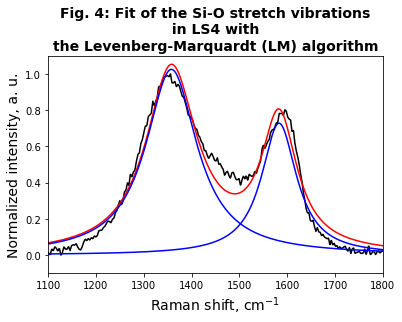

In [243]:
algo = 'leastsq' # We will use the Levenberg-Marquart algorithm  
#               (Name,  Value,  Vary,   Min,  Max,  Expr) Here I directly initialize with fixed frequencies

params.add_many(('a1',     50,   True,    0, None,  None),
                ('f1',   1350,   False, 1340, 1360,  None),
                ('l1',     50,   True,   45,   65,  None),
#                 ('a2',   0.5,   True,  0,      4,  None),
#                 ('f2',   1450,  True, 1420,   1480,  None),
#                 ('l2',   40,   True,  25,   50,  None),
                ('a3',   50,   True,  0,      None,  None),
                ('f3',   1595,  False, 1580,   1600,  None),
                ('l3',   35,   True,  25,   45,  None)) 
#                 ('a2',   0.5,   True,  0,      None,  None),
#                 ('f2',   1380,  True, 1350,   1410,  None),
#                 ('l2',   39,   True,  20,   55,  None),  
#                 ('a3',   8.5,    True,    0,      None,  None),
#                 ('f3',   1590,  True, 1580,   1600,  None),
#                 ('l3',   20,   True,  10,   30,  None),  
#                 ('a4',   1.,   True,  0,      None,  None),
#                 ('f4',   1620,  True, 1600,    1640,  None),
#                 ('l4',   20,   True,  10,   30,  None)) 
#                 ('a5',   2.,   True,  0,      None,  None),
#                 ('f5',   1211,  True, 1180,   1220,  None),
#                 ('l5',   28,   True,  20,   45,  None))

result = lmfit.minimize(residual, params, method = algo, args=(x_fit, y_pu_mm[:,0]))

# we release the positions but contrain the FWMH and amplitude of all peaks 
params['f1'].vary = True
# params['f2'].vary = True
params['f3'].vary = True
# params['f4'].vary = True
# params['f5'].vary = True

result2 = lmfit.minimize(residual, params,method = algo, args=(x_fit, y_pu_mm[:,0]))
model = lmfit.fit_report(result2.params) # the report 
yout, peak1,peak3 = residual(result2.params,x_fit) # the different peaks
# rchi2 = (1/(float(len(y_fit))-15-1))*np.sum((y_fit - yout)**2/sigma**2) # calculation of the reduced chi-square 

##### WE DO A NICE FIGURE THAT CAN BE IMPROVED FOR PUBLICATION
plt.plot(x_fit,y_pu_mm,'k-')
plt.plot(x_fit,yout,'r-')
plt.plot(x_fit,peak1,'b-')
# plt.plot(x_fit,peak2,'b-')
plt.plot(x_fit,peak3,'b-')
# plt.plot(x_fit,peak4,'b-')
# plt.plot(x_fit,peak5,'b-')
    
plt.xlim(lb,hb)
plt.ylim(-0.1,1.1)
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)
plt.title("Fig. 4: Fit of the Si-O stretch vibrations\n in LS4 with \nthe Levenberg-Marquardt (LM) algorithm",fontsize = 14,fontweight = "bold")
# print("rchi-2 = \n"+str(rchi2))
plt.savefig(path/'fig4.png', format='png', dpi=300)

In [244]:
print(model)

[[Variables]]
    a1:  209.296213 +/- 2.17629582 (1.04%) (init = 50)
    f1:  1357.84787 +/- 0.56866279 (0.04%) (init = 1350)
    l1:  64.9999997 +/- 1.11274257 (1.71%) (init = 50)
    a3:  102.898224 +/- 1.81733520 (1.77%) (init = 50)
    f3:  1582.90731 +/- 0.65773669 (0.04%) (init = 1595)
    l3:  44.9998195 +/- 0.97446247 (2.17%) (init = 35)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, l1) = -0.786
    C(a3, l3) =  0.778
    C(a1, a3) = -0.550
    C(l1, a3) =  0.460
    C(a1, l3) = -0.433
    C(l1, l3) =  0.330
    C(f1, a3) = -0.237
    C(f1, l3) = -0.195
    C(a1, f3) =  0.179
    C(l1, f3) = -0.151
    C(a1, f1) =  0.137
    C(f1, l1) = -0.113
    C(a3, f3) = -0.110
    C(f1, f3) =  0.103


The comparison of Fig. 3 and 4 shows small differences. In this case, and because we have a good error model, the LM algorithm converges toward results similar to those of the Nelder-Mead algorithm. You can try to run again the calculation with removing the "sigma" input in the "minimize" function used above. You will see that the results will diverge much more than in this case. 

A convenient thing about the LM algorithm is that it allows to estimate the errors on the fitting parameters. This is not possible with gradient-less algorithms such as the Nelder-Mear or the Powell algorithms. For the latters, I will give a piece of code at the end of this notebook that allows to estimate good errors on parameters through bootrapping. 

The downside of the LM algorithm is that, in my experience, it fails if the envelop of bands to fit is broader than the one used in this example, because it seachs at all costs to fit the spectrum as good as possible... This typically results in extrem broadening and overlapping of the peaks you try to fit.

A way to resolve this issue if the use of the LM algorithm is really needed is to put tigther constrains on the peak half-widths.

But another way is to use a more global algorithm less prone to diverge from the initial estimations. The Nelder-Mead, Powell (Powell, 1964, Computer Journal 7 (2): 155-62) or the COBYLA (see Powell, 2007 Cambridge University Technical Report DAMTP 2007) algorithms can give good results for complex problems. Also, the Conjugate Gradient algorithm may be suitable (Wright & Nocedal, “Numerical Optimization”, 1999, pp. 120-122). Let's try the latter for now:

rchi-2 = 
16892440.938808743


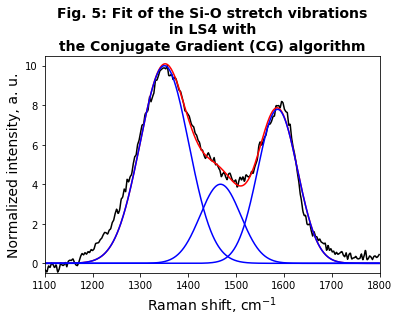

In [372]:
algo = 'cg' # We will use the Conjugate Gradient algorithm  
#               (Name,  Value,  Vary,   Min,  Max,  Expr) Here I directly initialize with fixed frequencies
params.add_many(('a1',   5,   True,  0,      10,  None),
                ('f1',   1355,   False, 1350,    1360,  None),
                ('l1',   45,   True,  40,      60,  None),
                ('a2',   0.5,   True,  0,      4,  None),
                ('f2',   1450,  False, 1420,   1480,  None),
                ('l2',   40,   True,  25,   50,  None),
                ('a3',   5,   True,  0,      None,  None),
                ('f3',   1590,  False, 1580,   1595,  None),
                ('l3',   40,   True,  25,   50,  None)) 
#                 ('a2',   0.5,   True,  0,      None,  None),
#                 ('f2',   1380,  True, 1350,   1410,  None),
#                 ('l2',   39,   True,  20,   55,  None),  
#                 ('a3',   8.5,    True,    0,      None,  None),
#                 ('f3',   1590,  True, 1580,   1600,  None),
#                 ('l3',   20,   True,  10,   30,  None),  
#                 ('a4',   1.,   True,  0,      None,  None),
#                 ('f4',   1620,  True, 1600,    1640,  None),
#                 ('l4',   20,   True,  10,   30,  None))   
#                 ('a5',   2.,   True,  0,      None,  None),
#                 ('f5',   1211,  True, 1180,   1220,  None),
#                 ('l5',   28,   True,  20,   45,  None))

result = lmfit.minimize(residual, params, method = algo, args=(x_fit, y_fit[:,0]))
# we release the positions but contrain the FWMH and amplitude of all peaks 
params['f1'].vary = True
params['f2'].vary = True
params['f3'].vary = True
# params['f4'].vary = True
# params['f5'].vary = True

result2 = lmfit.minimize(residual, params,method = algo, args=(x_fit, y_fit[:,0]))
model = lmfit.fit_report(result2.params) # the report 
yout, peak1,peak2,peak3 = residual(result2.params,x_fit) # the different peaks
rchi2 = (1/(float(len(y_fit))-15-1))*np.sum((y_fit - yout)**2/sigma**2) # calculation of the reduced chi-square 

##### WE DO A NICE FIGURE THAT CAN BE IMPROVED FOR PUBLICATION
plt.plot(x_fit,y_fit,'k-')
plt.plot(x_fit,yout,'r-')
plt.plot(x_fit,peak1,'b-')
plt.plot(x_fit,peak2,'b-')
plt.plot(x_fit,peak3,'b-')
# plt.plot(x_fit,peak4,'b-')
# plt.plot(x_fit,peak5,'b-')
    
plt.xlim(lb,hb)
plt.ylim(-0.5,10.5)
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)
plt.title("Fig. 5: Fit of the Si-O stretch vibrations\n in LS4 with \nthe Conjugate Gradient (CG) algorithm",fontsize = 14,fontweight = "bold")
print("rchi-2 = \n"+str(rchi2))
plt.savefig(path/'fig5.png', format='png', dpi=300)

In [373]:
print(model)

[[Variables]]
    a1:  10.00000000 (init = 5)
    f1:  1350.00000 (init = 1355)
    l1:  60.0000000 (init = 45)
    a2:  4.00000000 (init = 0.5)
    f2:  1467.25225 (init = 1450)
    l2:  50.0000000 (init = 40)
    a3:  7.79042877 (init = 5)
    f3:  1586.72196 (init = 1590)
    l3:  49.0679238 (init = 40)


The CG algorithm returns a result close to the Nelder-Mead and the LM algorithms. A bad thing about the CG algorithm is that it is extremely slow in the Scipy implementation... It is (nearly) acceptable for one fit, but for bootstrapping 100 spectra, it is not a good option at all.

As a last one, we can see what the results look like with the Powell algorithm:

rchi-2 = 
16892458.731023267


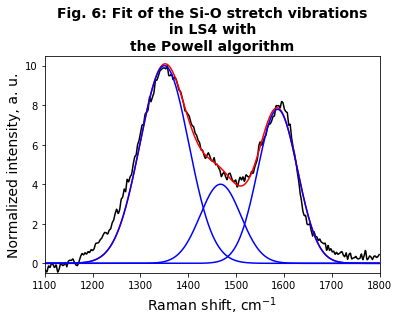

In [374]:
algo = 'powell' # We will use the Powell algorithm  
#               (Name,  Value,  Vary,   Min,  Max,  Expr) Here I directly initialize with fixed frequencies
params.add_many(('a1',   5,   True,  0,      10,  None),
                ('f1',   1355,   False, 1350,    1360,  None),
                ('l1',   45,   True,  40,      60,  None),
                ('a2',   0.5,   True,  0,      4,  None),
                ('f2',   1450,  False, 1420,   1480,  None),
                ('l2',   40,   True,  25,   50,  None),
                ('a3',   5,   True,  0,      None,  None),
                ('f3',   1590,  False, 1580,   1595,  None),
                ('l3',   40,   True,  25,   50,  None)) 
#                 ('a2',   0.5,   True,  0,      None,  None),
#                 ('f2',   1380,  True, 1350,   1410,  None),
#                 ('l2',   39,   True,  20,   55,  None),  
#                 ('a3',   8.5,    True,    0,      None,  None),
#                 ('f3',   1590,  True, 1580,   1600,  None),
#                 ('l3',   20,   True,  10,   30,  None),  
#                 ('a4',   1.,   True,  0,      None,  None),
#                 ('f4',   1620,  True, 1600,    1640,  None),
#                 ('l4',   20,   True,  10,   30,  None))  
#                 ('a5',   2.,   True,  0,      None,  None),
#                 ('f5',   1211,  True, 1180,   1220,  None),
#                 ('l5',   28,   True,  20,   45,  None))

result = lmfit.minimize(residual, params, method = algo, args=(x_fit, y_fit[:,0]))
# we release the positions but contrain the FWMH and amplitude of all peaks 
params['f1'].vary = True
params['f2'].vary = True
params['f3'].vary = True
# params['f4'].vary = True
# params['f5'].vary = True

result2 = lmfit.minimize(residual, params,method = algo, args=(x_fit, y_fit[:,0]))
model = lmfit.fit_report(result2.params) # the report 
yout, peak1,peak2,peak3 = residual(result2.params,x_fit) # the different peaks
rchi2 = (1/(float(len(y_fit))-15-1))*np.sum((y_fit - yout)**2/sigma**2) # calculation of the reduced chi-square 

##### WE DO A NICE FIGURE THAT CAN BE IMPROVED FOR PUBLICATION
plt.plot(x_fit,y_fit,'k-')
plt.plot(x_fit,yout,'r-')
plt.plot(x_fit,peak1,'b-')
plt.plot(x_fit,peak2,'b-')
plt.plot(x_fit,peak3,'b-')
# plt.plot(x_fit,peak4,'b-')
# plt.plot(x_fit,peak5,'b-')
    
plt.xlim(lb,hb)
plt.ylim(-0.5,10.5)
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)
plt.title("Fig. 6: Fit of the Si-O stretch vibrations\n in LS4 with \nthe Powell algorithm",fontsize = 14,fontweight = "bold")
print("rchi-2 = \n"+str(rchi2))
plt.savefig(path/'fig6.png', format='png', dpi=300)

In [375]:
print(model)

[[Variables]]
    a1:  10.0000000 (init = 5)
    f1:  1350.00000 (init = 1355)
    l1:  60.0000000 (init = 45)
    a2:  4.00000000 (init = 0.5)
    f2:  1467.24548 (init = 1450)
    l2:  50.0000000 (init = 40)
    a3:  7.79081266 (init = 5)
    f3:  1586.72045 (init = 1590)
    l3:  49.0663815 (init = 40)


You see in Fig. 6 that the results are, again, close to those of the other algorithms, at the exception of the two last peaks. The intensity and the frequency of the peak near 1200 cm$^{-1}$ is higher in this fit than in the others.

So one important thing that has to be remembered is that, with the same parameter inputs, you will obtain different results with using different fitting algorithms. The above results are close because the fitting example is quite simple. Actually, all the results given above seem reasonable. The experience with other spectra from other silicate and aluminosilicate glasses is that the Nelder-Mead and Powell algorithms will provide the most robust ways to fit the spectra.

In [306]:
def show_plots(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

params.add_many(('a1',   5,   True,  0,      10,  None),
                ('f1',   1355,   True, 1350,    1360,  None),
                ('l1',   45,   True,  40,      60,  None),
                ('a2',   0.5,   True,  0,      4,  None),
                ('f2',   1450,  True, 1420,   1480,  None),
                ('l2',   40,   True,  25,   50,  None),
                ('a3',   5,   True,  0,      None,  None),
                ('f3',   1590,  True, 1580,   1595,  None),
                ('l3',   40,   True,  25,   50,  None))
    
def show_plts(fn, parameters, method):
    result = lmfit.minimize(fn, parameters, method, args=(x_fit, y_fit[:,0]))
    params['f1'].vary = True
    params['f2'].vary = True
    params['f3'].vary = True
    result2 = lmfit.minimize(fn, parameters, method, args=(x_fit, y_fit[:,0]))
    model = lmfit.fit_report(result2.params) # the report 
    yout, peak1,peak2,peak3 = residual(result2.params,x_fit) # the different peaks
#     rchi2 = (1/(float(len(y_fit))-15-1))*np.sum((y_fit - yout)**2/sigma**2) # calculation of the reduced chi-square
    
    plt.plot(x_fit,y_fit,'k-')
    plt.plot(x_fit,yout,'r-')
    plt.plot(x_fit,peak1,'b-')
    plt.plot(x_fit,peak2,'b-')
    plt.plot(x_fit,peak3,'b-')
    
#     plt.xlim(lb,hb)
#     plt.ylim(-0.5,10.5)
#     plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
#     plt.ylabel("Normalized intensity, a. u.", fontsize = 14)
#     plt.title("Fig. 6: Fit of the Si-O stretch vibrations\n in LS4 with \nthe Powell algorithm",fontsize = 14,fontweight = "bold")

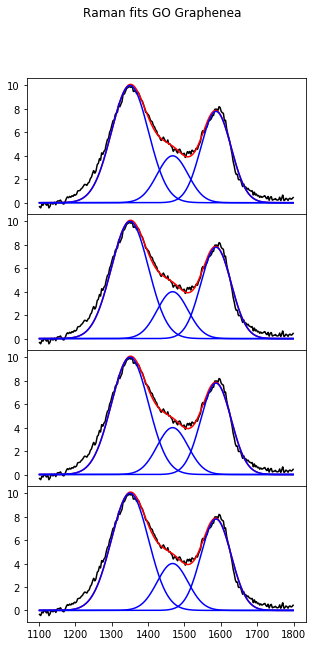

In [328]:
#Share both X and Y axes with all subplots
f, axarr = plt.subplots(4, sharex=True, sharey=True,figsize=(5,10))
f.suptitle('Raman fits GO Graphenea')

result = lmfit.minimize(residual, params, method = 'nelder', args=(x_fit, y_fit[:,0]))
params['f1'].vary = True
params['f2'].vary = True
params['f3'].vary = True
result2 = lmfit.minimize(residual, params, method = 'nelder', args=(x_fit, y_fit[:,0]))
model = lmfit.fit_report(result2.params) # the report 
yout, peak1,peak2,peak3 = residual(result2.params,x_fit) # the different peaks
#     rchi2 = (1/(float(len(y_fit))-15-1))*np.sum((y_fit - yout)**2/sigma**2) # calculation of the reduced chi-square

axarr[0].plot(x_fit,y_fit,'k-')
axarr[0].plot(x_fit,yout,'r-')
axarr[0].plot(x_fit,peak1,'b-')
axarr[0].plot(x_fit,peak2,'b-')
axarr[0].plot(x_fit,peak3,'b-')

result = lmfit.minimize(residual, params, method = 'leastsq', args=(x_fit, y_fit[:,0]))
params['f1'].vary = True
params['f2'].vary = True
params['f3'].vary = True
result2 = lmfit.minimize(residual, params, method = 'leastsq', args=(x_fit, y_fit[:,0]))
model = lmfit.fit_report(result2.params) # the report 
yout, peak1,peak2,peak3 = residual(result2.params,x_fit) # the different peaks
#     rchi2 = (1/(float(len(y_fit))-15-1))*np.sum((y_fit - yout)**2/sigma**2) # calculation of the reduced chi-square

axarr[1].plot(x_fit,y_fit,'k-')
axarr[1].plot(x_fit,yout,'r-')
axarr[1].plot(x_fit,peak1,'b-')
axarr[1].plot(x_fit,peak2,'b-')
axarr[1].plot(x_fit,peak3,'b-')

result = lmfit.minimize(residual, params, method = 'cg', args=(x_fit, y_fit[:,0]))
params['f1'].vary = True
params['f2'].vary = True
params['f3'].vary = True
result2 = lmfit.minimize(residual, params, method = 'cg', args=(x_fit, y_fit[:,0]))
model = lmfit.fit_report(result2.params) # the report 
yout, peak1,peak2,peak3 = residual(result2.params,x_fit) # the different peaks
#     rchi2 = (1/(float(len(y_fit))-15-1))*np.sum((y_fit - yout)**2/sigma**2) # calculation of the reduced chi-square

axarr[2].plot(x_fit,y_fit,'k-')
axarr[2].plot(x_fit,yout,'r-')
axarr[2].plot(x_fit,peak1,'b-')
axarr[2].plot(x_fit,peak2,'b-')
axarr[2].plot(x_fit,peak3,'b-')

result = lmfit.minimize(residual, params, method = 'powell', args=(x_fit, y_fit[:,0]))
params['f1'].vary = True
params['f2'].vary = True
params['f3'].vary = True
result2 = lmfit.minimize(residual, params, method = 'powell', args=(x_fit, y_fit[:,0]))
model = lmfit.fit_report(result2.params) # the report 
yout, peak1,peak2,peak3 = residual(result2.params,x_fit) # the different peaks
#     rchi2 = (1/(float(len(y_fit))-15-1))*np.sum((y_fit - yout)**2/sigma**2) # calculation of the reduced chi-square

axarr[3].plot(x_fit,y_fit,'k-')
axarr[3].plot(x_fit,yout,'r-')
axarr[3].plot(x_fit,peak1,'b-')
axarr[3].plot(x_fit,peak2,'b-')
axarr[3].plot(x_fit,peak3,'b-')

# Bring subplots close to each other.
f.subplots_adjust(hspace=0)

# Hide x labels and tick labels for all but bottom plot.
for ax in axarr:
    ax.label_outer()



# #Note that this is the same as
# plt.subplots(2, 2, sharex=True, sharey=True)

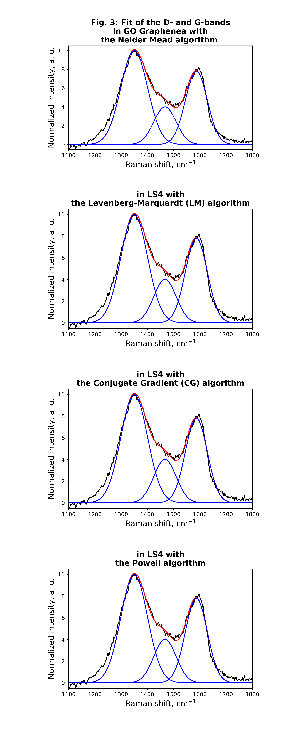

In [291]:
fig, axes = plt.subplots(4, 1, figsize=(10, 10))
for i,ax in enumerate(axes.flat): show_image(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

# Error estimations

Errors can be estimated with using the "confidence" function if you used the Levenberg-Marquardt algorithm. See the examples here: http://lmfit.github.io/lmfit-py/confidence.html .

If you use a large-scale gradient-less algorithm such as the Nelder-Mead or the Powell algorithms, you cannot do that. Thus, to calculate the errors on the parameters that those algorithms provide as well as the error introduced by choosing one or the other algorithm, we can use the bootstrapping technic. Several descriptions on the internet are available for this technic, so I will skip a complete description here.

A quick overview is to say that we have datapoints Yi affected by errors e_Yi. We assume that the probability density function of the Yi points is Gaussian. According to the Central Theorem Limit, this probably is a good assumption. Therefore, for each frequency in the spectrum of Fig.1, we have points that are probably at an intensity of Yi but with an error of e_Yi. To estimate how this uncertainties affect our fitting results, we can pick new points in the Gaussian distribution of mean Yi with a standard deviation e_Yi, and construct whole new spectra that we will fit. We will repeat this procedure N times.

In addition to that, we can also randomly choose between the Nelder-Mead or the Powell algorithm during the new fits, such that we will take also into account our arbitrary choice in the fitting algorithm for calculating the errors on the estimated parameters.

A last thing would be to randomly change a little bit the initial values of the parameters, but this is harder to implement so we will not do it for this example.

First of all, we have to write a Python function that will randomly sample the probability density functions of the points of the spectrum of Fig. 1. Here is the piece of code I wrote for doing so:

In [216]:
#### Bootstrap function
def bootstrap(data, ese,nbsample):
    # Bootstrap of Raman spectra. We generate new datapoints with the basis of existing data and their standard deviation
    N = len(data)
    bootsamples = np.zeros((N,nbsample))
    
    for i in range(nbsample):
        for j in range(N):
            bootsamples[j,i] = np.random.normal(data[j], ese[j], size=None)
    return bootsamples

Now we will define how much new spectra we want to generate (the nbsample option of the bootstrap function), and we will run the previous function.

In [217]:
%%time
nboot = 10 # Number of bootstrap samples, I set it to a low value for the example but usually you want thousands there
data_resampled = bootstrap(y_fit[:,0],sigma,nboot)# resampling of data + generate the output parameter tensor

CPU times: user 29.3 ms, sys: 13.4 ms, total: 42.7 ms
Wall time: 33.6 ms


Now, we will create a loop which is going to look at each spectrum in the data_resampled variable, and to fit them with the procedure already described.

For doing so, we need to declare a couple of variables to record the bootstrap mean fitting error, in order to see if we generated enought samples to obtain a statistically representative bootstrapping process, and to record each set of parameters obtained for each bootstrapped spectrum.

In [219]:
para_output = np.zeros((5,3,nboot)) # 5 x 3 parameters x N boot samples
bootrecord = np.zeros((nboot)) # For recording boot strap efficiency
        
for nn in range(nboot):
    algos = ['powell','nelder']
    algo = random.choice(algos) # We randomly select between the Powell or Nelder_mear algorithm
    params = lmfit.Parameters()
    #               (Name,  Value,  Vary,   Min,  Max,  Expr) Here I directly initialize with fixed frequencies
    params.add_many(('a1',   5,   True,  0,      10,  None),
                ('f1',   1355,   True, 1350,    1360,  None),
                ('l1',   45,   True,  40,      60,  None),
                ('a2',   0.5,   True,  0,      4,  None),
                ('f2',   1450,  True, 1420,   1480,  None),
                ('l2',   40,   True,  25,   50,  None),
                ('a3',   5,   True,  0,      None,  None),
                ('f3',   1590,  True, 1580,   1595,  None),
                ('l3',   40,   True,  25,   50,  None))  
#                 ('a5',   2.,   True,  0,      None,  None),
#                 ('f5',   1211,  True, 1180,   1220,  None),
#                 ('l5',   28,   True,  20,   45,  None))
    
#     params.add_many(('a1',   24,   True,  0,      None,  None),
#                 ('f1',   946,   True, 910,    970,  None),
#                 ('l1',   26,   True,  20,      50,  None),
#                 ('a2',   35,   True,  0,      None,  None),
#                 ('f2',   1026,  True, 990,   1070,  None),
#                 ('l2',   39,   True,  20,   55,  None),  
#                 ('a3',   85,    True,    70,      None,  None),
#                 ('f3',   1082,  True, 1070,   1110,  None),
#                 ('l3',   31,   True,  25,   35,  None),  
#                 ('a4',   22,   True,  0,      None,  None),
#                 ('f4',   1140,  True, 1110,    1160,  None),
#                 ('l4',   35,   True,  20,   50,  None),  
#                 ('a5',   4,   True,  0,      None,  None),
#                 ('f5',   1211,  True, 1180,   1220,  None),
#                 ('l5',   28,   True,  20,   45,  None))

    result = lmfit.minimize(residual, params, method = algo, args=(x_fit, data_resampled[:,nn],sigma))
    # we release the positions but contrain the FWMH and amplitude of all peaks 
    params['f1'].vary = True
    params['f2'].vary = True
    params['f3'].vary = True
#     params['f4'].vary = True
#     params['f5'].vary = True

    result2 = lmfit.minimize(residual, params,method = algo, args=(x_fit, data_resampled[:,nn], sigma))
                           
    vv = result2.params.valuesdict()
    para_output[0,0,nn] = vv['a1']
    para_output[1,0,nn] = vv['a2']
    para_output[2,0,nn] = vv['a3']
#     para_output[3,0,nn] = vv['a4']
#     para_output[4,0,nn] = vv['a5']
            
    para_output[0,1,nn] = vv['f1']
    para_output[1,1,nn] = vv['f2']
    para_output[2,1,nn] = vv['f3']
#     para_output[3,1,nn] = vv['f4']
#     para_output[4,1,nn] = vv['f5']
            
    para_output[0,2,nn] = vv['l1']
    para_output[1,2,nn] = vv['l2']
    para_output[2,2,nn] = vv['l3']
#     para_output[3,2,nn] = vv['l4']
#     para_output[4,2,nn] = vv['l5']
                
para_mean = np.mean(para_output,axis=2)
para_ese = np.std(para_output,axis=2)
for kjy in range(nboot):
    if kjy == 0:
        bootrecord[kjy] = 0
    else:
        bootrecord[kjy] = np.sum(np.std(para_output[:,:,0:kjy],axis=2))

We can have a view at the mean values and standard deviation of the parameters that have been generated by the bootstrapping:

In [220]:
para_mean

array([[   9.613066, 1351.395886,   59.99881 ],
       [   3.957098, 1459.961573,   49.726165],
       [   7.792543, 1585.336684,   49.973485],
       [   0.      ,    0.      ,    0.      ],
       [   0.      ,    0.      ,    0.      ]])

In [221]:
para_ese

array([[5.035810e-01, 2.108245e+00, 3.452323e-03],
       [9.319522e-02, 1.386482e+01, 7.028280e-01],
       [2.837316e-01, 2.500119e+00, 6.974312e-02],
       [0.000000e+00, 0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00]])

Those errors are probably the best estimates of the errors that affect your fitting parameters. You can add another bootstrapping function for changing of, saying, 5 percents the initial estimations of the parameters, and you will have a complete and coherent estimation of the errors affecting the fits. But for most cases, the errors generated by this above bootstrapping technic are already quite robust.

We can see if we generated enought samples to have valid bootstrap results by looking at how the mean value of the parameters and their error converge. To do a short version of such thing, we can also look at how the summation of the errors of the parameters change with the iteration number. If the summation of errors becomes constant, we can say that we have generated enought bootstrap samples to have a significant result, statistically speaking.

Text(0.5, 1.0, 'Fig. 7: Bootstrap iterations for convergence')

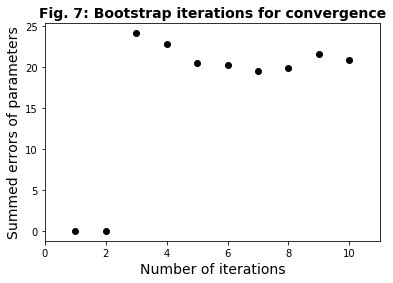

In [222]:
plt.plot(np.arange(nboot)+1,bootrecord,'ko')
plt.xlim(0,nboot+1)
plt.xlabel("Number of iterations",fontsize = 14)
plt.ylabel("Summed errors of parameters",fontsize = 14)
plt.title("Fig. 7: Bootstrap iterations for convergence",fontsize = 14, fontweight = 'bold')

We see from the above figure that the algorithm seems to have converged after 70 iterations. Therefore, we need to generate at least 70 spectra with the bootstrap function to obtain a good estimate of the errors that affect the parameters.

# Conclusion
This IPython notebook showed how spectra can be corrected from any baseline, how it is possible to use lmfit to fit it with Gaussian peaks, how changing the optimisation algorithm can change the results, and how we can estimate the errors on the calculated parameters with using the bootstrapping technic.

Several peak models are defined in the Rampy toolbox, or directly in lmfit. You can look at the relevant instructions for both software to use other peak models in the above calculation. Results can be saved in textfiles, through using the Python output functions like np.savetxt or other ways. See the relevant python documentation for doing so. Any comments on this program will be welcome.

In [261]:
!jupyter nbconvert --to script Raman-Ana.ipynb

[NbConvertApp] Converting notebook Raman-Ana.ipynb to script
[NbConvertApp] Writing 34167 bytes to Raman-Ana.py
